In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from scipy import stats, spatial
import processing

In [3]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import statsmodels.api as sm

In [4]:
words = pd.read_csv('./data/words.csv')

In [5]:
log = pd.read_csv('./data/log_valid_processed.csv')

In [6]:
participants = pd.read_csv('./data/participants_processed.csv',index_col=0)
participants = participants.loc[participants.index.isin(log.participant_id.unique())].copy()

This contains a bunch of legacy data exploration code. It most often will not work without some tinkering (file paths, variable names, etc.). It is not deleted in case we want to go revisit some topics. For a fuller notebook, explore earlier commits (especially before September 2019).

## Distance model

In [38]:
# Prepare distance model
qwerty = [
    'qwertyuiop',
    'asdfghjkl',
    'zxcvbnm'
]
tmp = qwerty
for i,line in enumerate(tmp):
    qwerty[i] = list(line)
    
tmp = qwerty
qwerty = {}

# Invert so we have indices
for i,line in enumerate(tmp):
    for j,char in enumerate(line):
        qwerty[char] = [i,j]
qwerty = pd.DataFrame(qwerty).T

# Offset the rows
qwerty.loc[qwerty[0] == 1, 1] += 0.5
qwerty.loc[qwerty[0] == 2, 1] += 1.5

qwerty_dist = spatial.distance_matrix(qwerty,qwerty,p=1)
qwerty_dist = pd.DataFrame(qwerty_dist,index=qwerty.index,columns=qwerty.index)

# Flatten
tmp = qwerty_dist.copy()
qwerty_dist = {}
for i in tmp.index:
    for j in tmp.columns:
        qwerty_dist[i+j] = tmp.loc[i,j]

def get_distance(x):
    d = 0
    for i,c in enumerate(x[1:]):
        d += qwerty_dist[x[i:i+2]]
    return d

## Time series analysis

In [128]:
data = log[['participant_id','ts_id','entry_id','iki','key','ite']].copy()

# First iki of each word is undefined
data.loc[data.groupby(['ts_id','entry_id']).head(1).index, 'iki'] = np.nan

# Create artificial timestamp based on the iki
data['iki_rel'] = data.iki / data.participant_id.map(participants.iki_natural)
data['timestamp'] = data.groupby(['ts_id','entry_id']).iki.cumsum()
data['timestamp_rel'] = data.groupby(['ts_id','entry_id']).iki_rel.cumsum()
data.loc[data.groupby(['ts_id','entry_id']).head(1).index, 'timestamp'] = 0
data.loc[data.groupby(['ts_id','entry_id']).head(1).index, 'timestamp_rel'] = 0

# Some processing requires indexing based on ts and entry id's
data.set_index(['ts_id','entry_id'], inplace=True)
data = data.drop(data.loc[~data.key.str.contains('[a-zA-Z]')].index) # Remove entries with backspace, punctuation, numbers
data['ite'] = words.set_index(['ts_id','entry_id']).ite
data['ite2'] = words.set_index(['ts_id','entry_id']).ite2
data['word'] = words.set_index(['ts_id','entry_id']).word
data['word_length'] = words.set_index(['ts_id','entry_id']).word_length
data.reset_index(inplace=True)

# Label each action within an entry
data['action_id'] = data.groupby(['ts_id','entry_id']).cumcount()

# Count the number of actions per entry
data.set_index(['ts_id','entry_id'], inplace=True)
data['n_actions'] = data.groupby(['ts_id','entry_id']).size()
data.reset_index(inplace=True)

In [370]:
words.loc[words.ite2 == 'completion'].word.value_counts().head(10)

tomorrow       164
Thursday       102
expected        90
information     90
questions       79
September       74
against         63
probably        61
available       56
anything        55
Name: word, dtype: int64

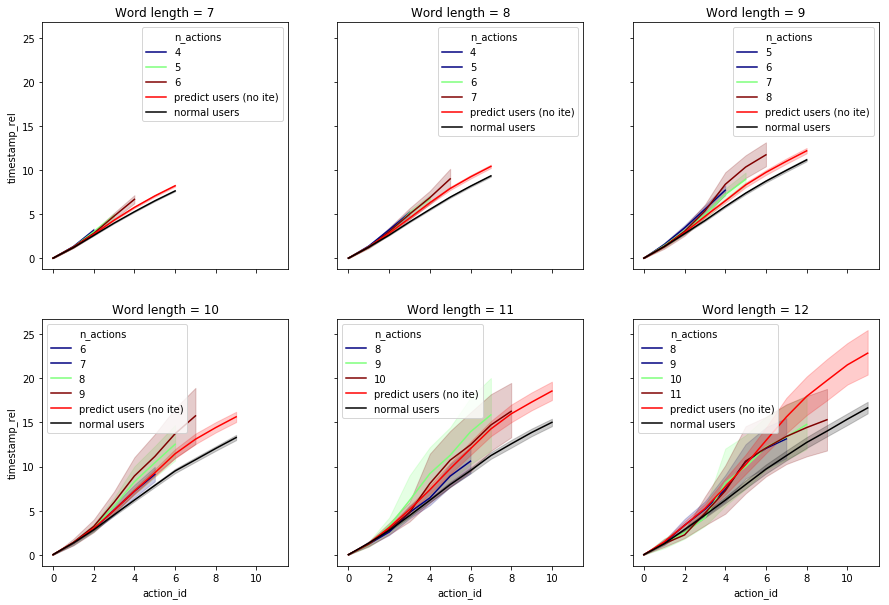

In [131]:
f,ax = plt.subplots(2,3,figsize=(15,10), sharex=True, sharey=True)
ax=ax.flatten()

tmp = data.loc[data.ite != 'autocorr'].copy()
tmp.ite2 = tmp.ite2.fillna('none')
tmp = tmp.loc[tmp.ite2.isin(['none','completion', 'correction'])]
mask = tmp.key.str.len() == 1
tmp = tmp.loc[mask]
for i in range(7,13):
    tmp2 = tmp.loc[tmp.word_length == i].copy()
    mask = ((tmp2.n_actions.isin(range(max(3,i-3),i))) & (tmp2.ite2 == 'completion'))
    mask |= ((tmp2.n_actions == i) & (tmp2.ite2 == 'none'))
    tmp2 = tmp2.loc[mask]
    
    tmp2 = tmp2.groupby(['ite2','n_actions','action_id']).filter(lambda x: x.shape[0] > 5)
    
    predict_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict) > 5]
    normal_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict)  < 4]
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=predict_users.loc[predict_users.ite2 == 'completion'],
        hue='n_actions',
        palette='jet',
        ax=ax[i-7]
    )
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=predict_users.loc[predict_users.ite == 'none'],
        ax=ax[i-7],
        color='r',
        label='predict users (no ite)'
    )
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=normal_users.loc[normal_users.ite == 'none'],
        ax=ax[i-7],
        color='k',
        label='normal users'
    )
    ax[i-7].set_title('Word length = {}'.format(i))

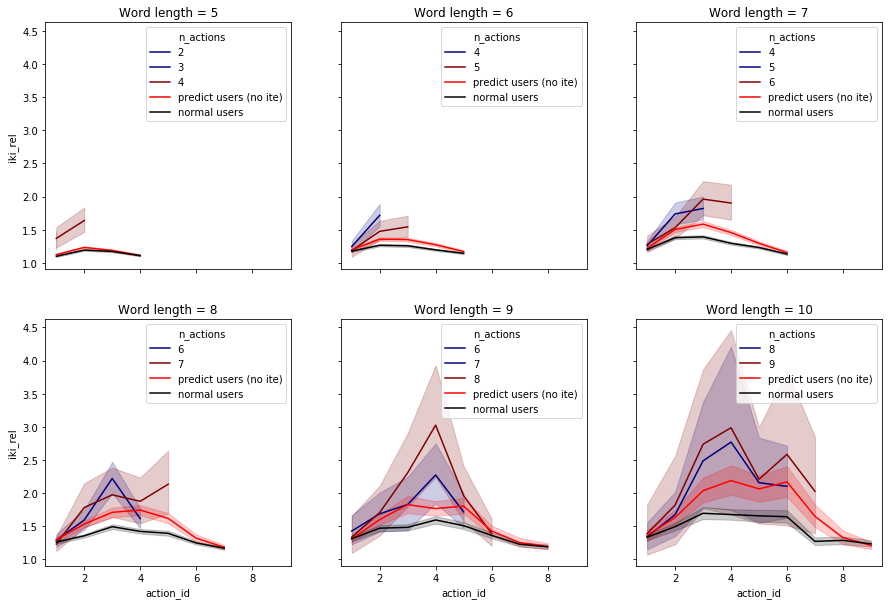

In [221]:
f,ax = plt.subplots(2,3,figsize=(15,10), sharex=True, sharey=True)
ax=ax.flatten()

tmp = data.loc[data.ite != 'autocorr'].copy()
tmp.ite2 = tmp.ite2.fillna('none')
tmp = tmp.loc[tmp.ite2.isin(['none','completion'])]
mask = tmp.key.str.len() == 1
tmp = tmp.loc[mask]
for i in range(5,11):
    tmp2 = tmp.loc[tmp.word_length == i].copy()
    mask = ((tmp2.n_actions.isin(range(max(3,i-2),i))) & (tmp2.ite2 == 'completion'))
    mask |= ((tmp2.n_actions == i) & (tmp2.ite2 == 'none'))
    tmp2 = tmp2.loc[mask]
    
    tmp2 = tmp2.groupby(['ite2','n_actions','action_id']).filter(lambda x: x.shape[0] > 5)
    
    predict_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict) > 5]
    normal_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict)  < 4]
    sns.lineplot(
        'action_id',
        'iki_rel',
        data=predict_users.loc[predict_users.ite2 == 'completion'],
        hue='n_actions',
        palette='jet',
        ax=ax[i-5]
    )
    sns.lineplot(
        'action_id',
        'iki_rel',
        data=predict_users.loc[predict_users.ite2 == 'none'],
        ax=ax[i-5],
        color='r',
        label='predict users (no ite)'
    )
    sns.lineplot(
        'action_id',
        'iki_rel',
        data=normal_users.loc[normal_users.ite2 == 'none'],
        ax=ax[i-5],
        color='k',
        label='normal users'
    )
    ax[i-5].set_title('Word length = {}'.format(i))

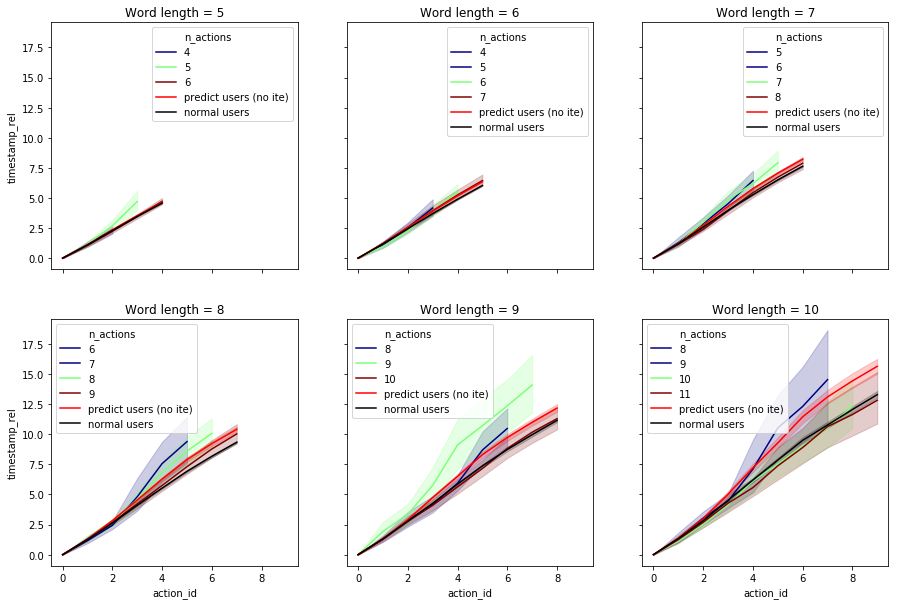

In [225]:
f,ax = plt.subplots(2,3,figsize=(15,10), sharex=True, sharey=True)
ax=ax.flatten()

tmp = data.loc[data.ite != 'autocorr'].copy()
tmp.ite2 = tmp.ite2.fillna('none')
tmp = tmp.loc[tmp.ite2.isin(['none','correction'])]
mask = tmp.key.str.len() == 1
tmp = tmp.loc[mask]
for i in range(5,11):
    tmp2 = tmp.loc[tmp.word_length == i].copy()
    mask = ((tmp2.n_actions.isin(range(max(3,i-1),i+2))) & (tmp2.ite2 == 'correction'))
    mask |= ((tmp2.n_actions == i) & (tmp2.ite2 == 'none'))
    tmp2 = tmp2.loc[mask]
    
    tmp2 = tmp2.groupby(['ite2','n_actions','action_id']).filter(lambda x: x.shape[0] > 5)
    
    predict_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict) > 5]
    normal_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict)  < 4]
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=predict_users.loc[predict_users.ite2 == 'correction'],
        hue='n_actions',
        palette='jet',
        ax=ax[i-5]
    )
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=predict_users.loc[predict_users.ite2 == 'none'],
        ax=ax[i-5],
        color='r',
        label='predict users (no ite)'
    )
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=normal_users.loc[normal_users.ite2 == 'none'],
        ax=ax[i-5],
        color='k',
        label='normal users'
    )
    ax[i-5].set_title('Word length = {}'.format(i))

## Example of how word length affects the strategy used

In [684]:
words.loc[(words.word_length < 6) & (words.ite2 != 'none')].ite2.value_counts(normalize=True)

correction        0.398561
completion        0.356575
prediction        0.100915
contraction       0.057805
other             0.038162
capitalization    0.034338
add_space         0.009897
no_change         0.001949
fixup             0.001799
Name: ite2, dtype: float64

In [685]:
words.loc[(words.word_length >= 6) & (words.ite2 != 'none')].ite2.value_counts(normalize=True)

completion        0.705443
correction        0.238203
capitalization    0.020570
contraction       0.012348
other             0.008883
prediction        0.008789
fixup             0.004190
add_space         0.001229
no_change         0.000347
Name: ite2, dtype: float64

## Do certain participants use prediction more than others?

In [528]:
data = words.groupby('ite').participant_id.value_counts(normalize=True, ascending=True).reset_index(1, drop=True)
data = data.groupby(data.index).cumsum()
data = data.reset_index()
data = data.reset_index()
data = data.rename(columns={'index':'participants','participant_id':'cumulative_share'})
data.participants = data.groupby('ite').participants.apply(lambda x: (x - x.min())/(x.max() - x.min()))

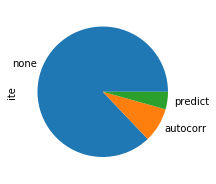

In [538]:
f,ax = plt.subplots(1,1,figsize=(3,3))

words.ite.value_counts(normalize=True).plot.pie(ax=ax)

ax.set_aspect('equal')

f.savefig('./figures/pie_ite_usage.png', dpi=300)

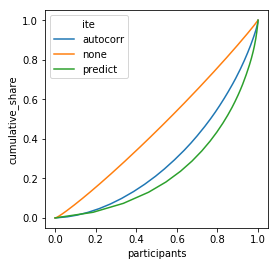

In [537]:
f,ax = plt.subplots(1,1,figsize=(4,4))
sns.lineplot(data.participants, data.cumulative_share, hue = data.ite, ax=ax)

f.savefig('./figures/lorenz_ite_usage.png', dpi=300)

In [540]:
data = words.groupby('ite2').participant_id.value_counts(normalize=True, ascending=True).reset_index(1, drop=True)
data = data.groupby(data.index).cumsum()
data = data.reset_index()
data = data.reset_index()
data = data.rename(columns={'index':'participants','participant_id':'cumulative_share'})
data.participants = data.groupby('ite2').participants.apply(lambda x: (x - x.min())/(x.max() - x.min()))

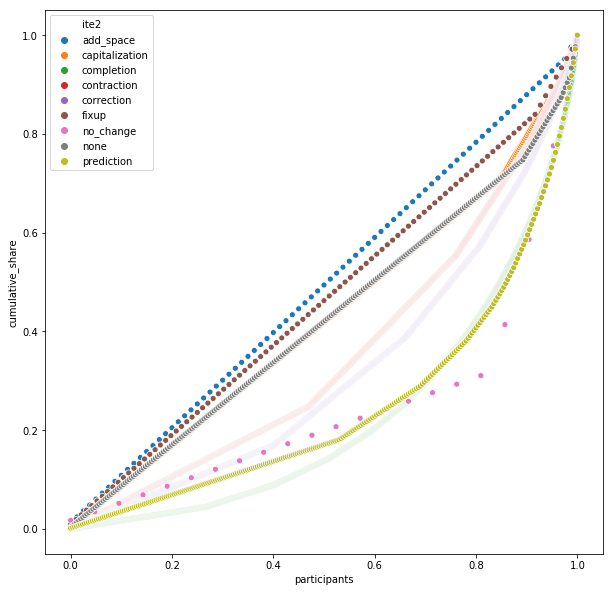

In [541]:
f,ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(data.participants, data.cumulative_share,hue=data.ite2, ax=ax)

In [58]:
data = participants_.loc[
    participants.n_predict > 2,
    ['AGE','GENDER','TIME_SPENT_TYPING','TYPE_ENGLISH','hands1','hands2']
].copy()
data = data.loc[data.AGE < 56].copy()

data['predict'] = participants_ite.predict
data.predict = stats.boxcox(data.predict)[0]

data['completion'] = participants_ite2.completion
data['correction'] = participants_ite2.correction

# Characters per second based on words where no ITE was used
data['natural_speed'] = words.loc[(words.ite == 'none') & (words.word_length < 5)].groupby('participant_id').iki_natural.mean()
data.natural_speed = np.reciprocal(data.natural_speed) * 1000

data['age_binned'] = pd.cut(data.AGE,[0,10,15,19,25,35,55])

data['experience_binned'] = pd.cut(data.TIME_SPENT_TYPING,6)

data['native_english'] = participants_.NATIVE_LANGUAGE == 'en'

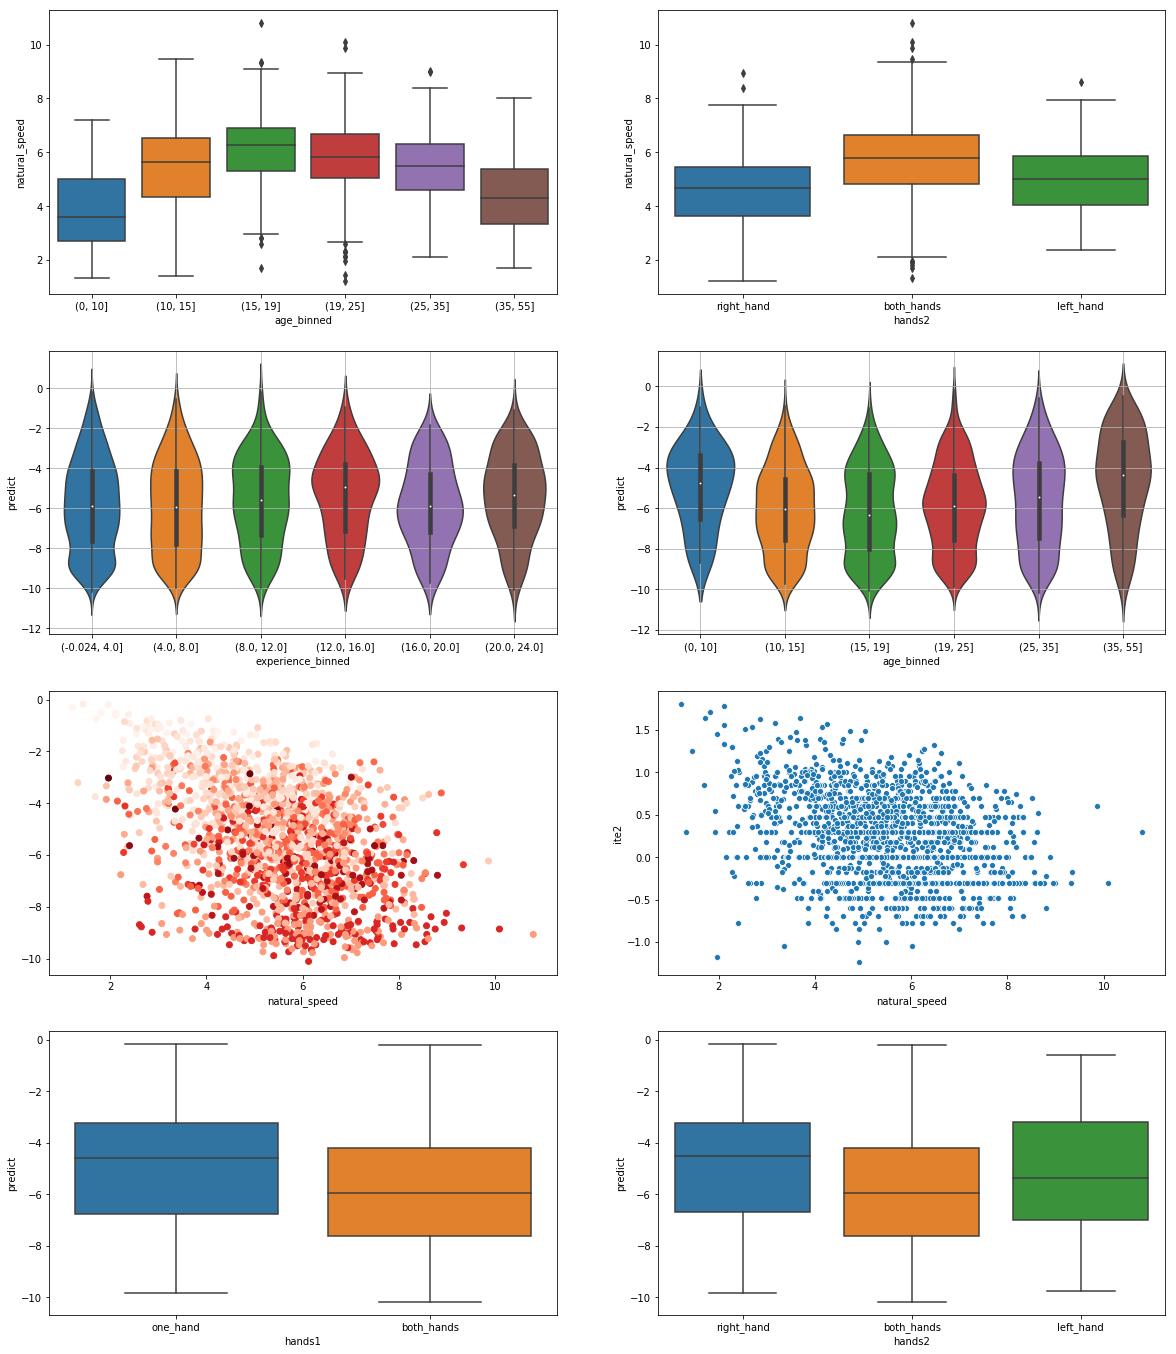

In [59]:
f,ax = plt.subplots(4,2,figsize=(20,24))
ax = ax.flatten()

sns.boxplot(data.age_binned, data.natural_speed,ax=ax[0])

sns.boxplot(data.hands2, data.natural_speed, ax=ax[1])

sns.violinplot(data.experience_binned, data.predict, ax=ax[2])
ax[2].grid()

sns.violinplot(data.age_binned, data.predict, ax=ax[3])
ax[3].grid()

data2 = data.loc[(data.completion > 0) & (data.correction > 0)].copy()
im = ax[4].scatter(data2.natural_speed, data2.predict, c=data2.correction, cmap='Reds')
ax[4].set_xlabel('natural_speed')
# f.colorbar(im,ax=ax[4])

data2 = data.loc[(data.completion > 0) & (data.correction > 0)].copy()
data2['ite2'] = np.log10(data2.completion/data2.correction)
sns.scatterplot(data2.natural_speed, data2.ite2, ax=ax[5])

sns.boxplot(data.hands1,data.predict,ax=ax[6])
sns.boxplot(data.hands2,data.predict,ax=ax[7])

## For what words is prediction used?

### Global analysis

Let's look at some general characteristics of prediction usage

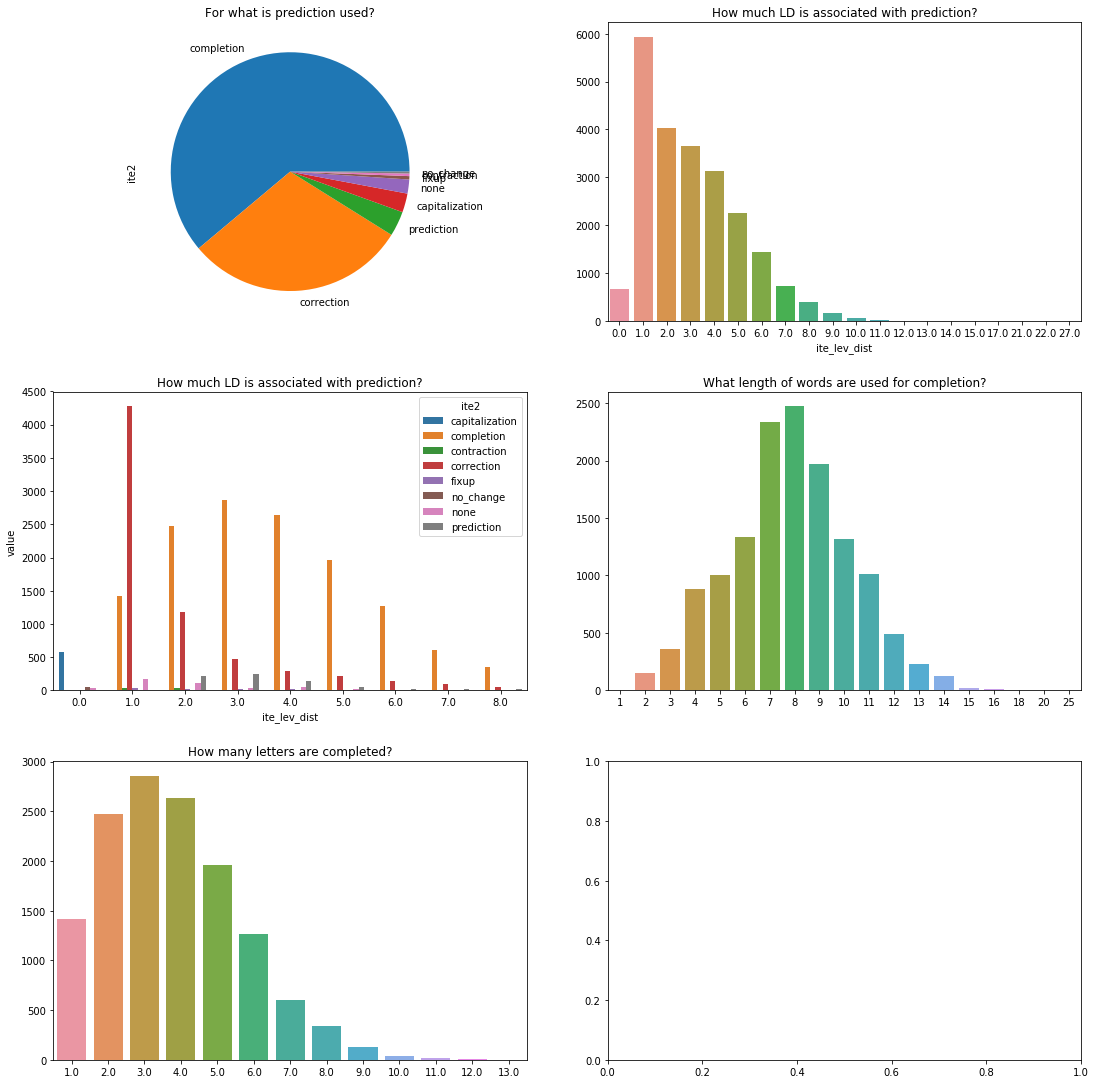

In [11]:
f,ax = plt.subplots(3,2,figsize=(15,15))
ax1,ax2,ax3,ax4,ax5,ax6=ax.flatten()

f.tight_layout(w_pad=5,h_pad=5)

ax1.set_title('For what is prediction used?')
data = words.loc[words.ite == 'predict']
data.ite2.value_counts(normalize=True).plot.pie(ax=ax1)
ax1.set_aspect('equal')

ax2.set_title('How much LD is associated with prediction?')
data = words.loc[words.ite == 'predict']
data = data.groupby('ite_lev_dist').size()
sns.barplot(data.index,data.values,ax=ax2)

ax3.set_title('How much LD is associated with prediction?')
data = words.loc[words.ite == 'predict']
data = data.loc[data.ite_lev_dist < 9]
data = data.groupby(['ite_lev_dist','ite2']).size().unstack().reset_index().melt('ite_lev_dist')
sns.barplot(data.ite_lev_dist,data.value,hue=data.ite2,ax=ax3)

ax4.set_title('What length of words are used for completion?')
data = words.loc[words.ite2 == 'completion']
data = data.ite_input.str.len().value_counts()
sns.barplot(data.index,data.values,ax=ax4)

ax5.set_title('How many letters are completed?')
data = words.loc[words.ite2 == 'completion']
data = data.ite_lev_dist.value_counts()
sns.barplot(data.index,data.values,ax=ax5)

### Is prediction used for certain words more than for others?

Text(63.125,0.5,'Probability')

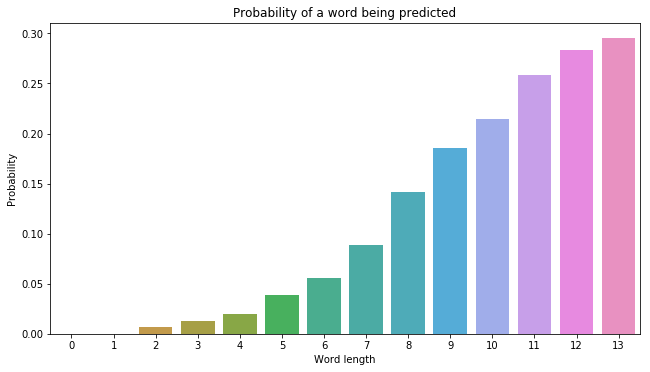

In [311]:
f,ax = plt.subplots(1,1,figsize=(10,6))
ax1 = ax

f.tight_layout(pad = 5)
ax1.set_title('Probability of a word being predicted')

# In the case of ITE, the input is equal to the final word
mask = (words.ite_input == words.word) | (words.ite == 'none')
# Very long words don't occur enough times to make a conclusion
data = words.loc[(words.word_length < 14) & mask]
data = data.groupby('word_length').ite.value_counts(normalize=True).unstack()['predict']
sns.barplot(data.index,data.values,ax=ax1)
ax1.set_xlabel('Word length')
ax1.set_ylabel('Probability')

In [ ]:
f.savefig('./figures/length_predict_probability.png',dpi=300)

Text(63.125,0.5,'Probability')

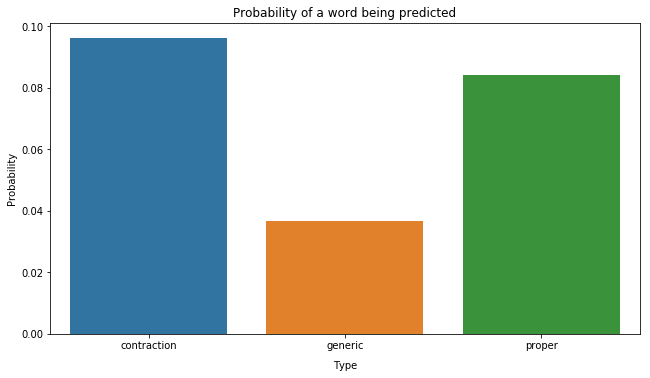

In [312]:
f,ax = plt.subplots(1,1,figsize=(10,6))
ax1 = ax

f.tight_layout(pad = 5)
ax1.set_title('Probability of a word being predicted')

# In the case of ITE, the input is equal to the final word
mask = (words.ite_input == words.word) | (words.ite == 'none')
# Very long words don't occur enough times to make a conclusion
data = words.loc[(words.word_length < 13) & mask]
data = data.groupby('type').ite.value_counts(normalize=True).unstack()['predict']
sns.barplot(data.index,data.values,ax=ax1)
ax1.set_xlabel('Type',labelpad=10)
ax1.set_ylabel('Probability')

In [ ]:
f.savefig('./figures/type_predict_probability.png',dpi=300)

Text(0,0.5,'Probability')

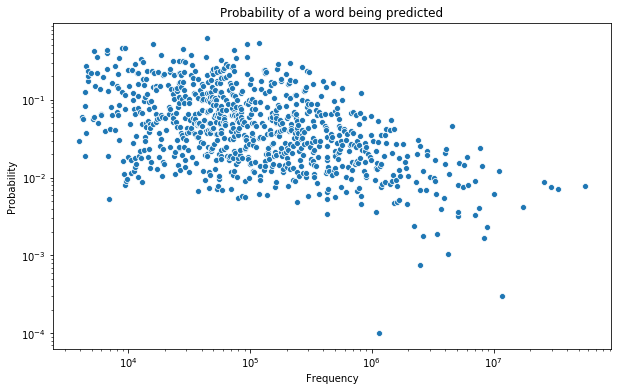

In [323]:
f,ax = plt.subplots(1,1,figsize=(10,6))
ax1 = ax

ax1.set_title('Probability of a word being predicted')
ax1.set_xscale('log')
ax1.set_yscale('log')

# In the case of ITE, the input is equal to the final word
mask = (words.ite_input == words.word) | (words.ite == 'none')
data = words.loc[(words.word_length < 13) & mask]
data = data.groupby('freq').ite.value_counts(normalize=True).unstack()['predict']
data = data.loc[words.groupby('freq').size() > 50]
data = data.reset_index()
sns.scatterplot(data.freq,data.predict,ax=ax1)

ax1.set_xlabel('Frequency')
ax1.set_ylabel('Probability')


In [ ]:
f.savefig('./figures/freq_predict_probability.png',dpi=300)

#### Measuring effort

In [13]:
qwerty = [
    'qwertyuiop',
    'asdfghjkl',
    'zxcvbnm'
]
tmp = qwerty
for i,line in enumerate(tmp):
    qwerty[i] = list(line)
    
tmp = qwerty
qwerty = {}
# Invert so we have indices
for i,line in enumerate(tmp):
    for j,char in enumerate(line):
        qwerty[char] = [i,j]
qwerty = pd.DataFrame(qwerty).T
# Offset the rows
qwerty.loc[qwerty[0] == 1, 1] += 0.5
qwerty.loc[qwerty[0] == 2, 1] += 1.5

qwerty_dist = spatial.distance_matrix(qwerty,qwerty,p=1)
qwerty_dist = pd.DataFrame(qwerty_dist,index=qwerty.index,columns=qwerty.index)

# Flatten
tmp = qwerty_dist.copy()
qwerty_dist = {}
for i in tmp.index:
    for j in tmp.columns:
        qwerty_dist[i+j] = tmp.loc[i,j]
        
qwerty_dist2 = qwerty[1].to_dict()

def get_effort1(x):
    d = 0
    for i,c in enumerate(x[1:]):
        d += qwerty_dist[x[i:i+2]]
    return d

def get_effort1_first3(x):
    for i,c in enumerate(x.word[1:4]):
        x['effort1_'+str(i)] = qwerty_dist[x.word[i:i+2]]
    return x

def get_effort2(x):
    d = 0
    for i,c in enumerate(x):
        d += qwerty_dist2[c]
    return d

def get_effort3(x):
    d = 0
    for c in ['q','a','z','p','l','m']:
        if c in x:
            d += 1
    return d

In [19]:
# mask &= words.word_length > 2
mask = words.iki_natural > 0
mask &= (words.word.str.contains('^[a-z]+$'))
mask &= (words.ite_input_prev.isna()) | (words.ite_input_prev.str.contains('^[a-z]+$'))
mask &= words.word_length < 13
data = words.loc[mask].copy()
data.ite2 = data.ite2.fillna('none')
data = data.groupby('word').filter(lambda x: x.shape[0] > 50)
data['effort1'] = data.word.map(get_effort1) / data.word_length
data['effort2'] = data.word.map(get_effort2) / data.word_length
data['effort1_prev'] = data.ite_input_prev.dropna().map(get_effort1) / data.ite_input_prev.dropna().str.len()
data['hands1'] = data.participant_id.map(participants_.hands1)
data['hands2'] = data.participant_id.map(participants_.hands2)

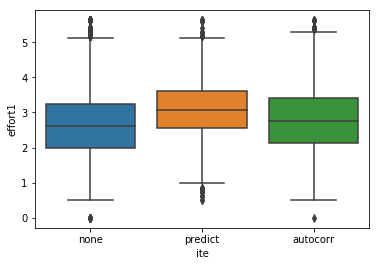

In [20]:
tmp = data.loc[data.hands1 == 'one_hand']
sns.boxplot('ite','effort1',data=tmp)

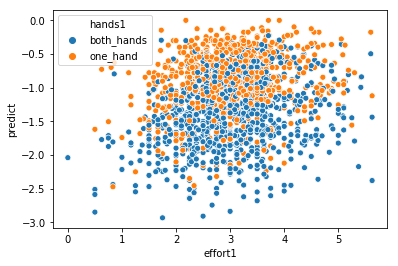

In [21]:
tmp = data.copy()
tmp = tmp.groupby(['word','effort1','effort2','hands1']).ite.value_counts(normalize=True).unstack()['predict']
tmp = tmp.reset_index()
tmp.predict = np.log10(tmp.predict)
sns.scatterplot('effort1','predict',data=tmp,hue='hands1')

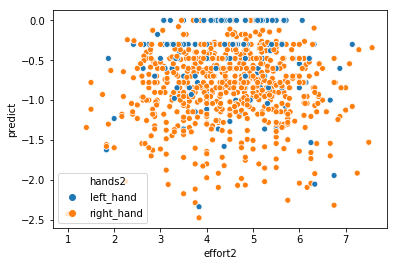

In [22]:
tmp = data.loc[data.hands1 == 'one_hand'].copy()
tmp = tmp.groupby(['word','effort1','effort2','hands2']).ite.value_counts(normalize=True).unstack()['predict']
tmp = tmp.reset_index().set_index('word')
tmp.predict = np.log10(tmp.predict)
sns.scatterplot('effort2','predict',data=tmp,hue='hands2')

## Comfort and Distance models

In [ ]:
qwerty = [
    'qwertyuiop',
    'asdfghjkl',
    'zxcvbnm'
]
tmp = qwerty
for i,line in enumerate(tmp):
    qwerty[i] = list(line)
    
tmp = qwerty
qwerty = {}
# Invert so we have indices
for i,line in enumerate(tmp):
    for j,char in enumerate(line):
        qwerty[char] = [i,j]
qwerty = pd.DataFrame(qwerty).T
# Offset the rows
qwerty.loc[qwerty[0] == 1, 1] += 0.5
qwerty.loc[qwerty[0] == 2, 1] += 1.5

qwerty_dist = spatial.distance_matrix(qwerty,qwerty,p=1)
qwerty_dist = pd.DataFrame(qwerty_dist,index=qwerty.index,columns=qwerty.index)

# Flatten
tmp = qwerty_dist.copy()
qwerty_dist = {}
for i in tmp.index:
    for j in tmp.columns:
        qwerty_dist[i+j] = tmp.loc[i,j]

qwerty_comfort_right = (4.5 - qwerty[1]).abs()
qwerty_comfort_left = 9 - qwerty_comfort_right
qwerty_comfort_both = qwerty_comfort_right

def get_effort(x):
    d = 0
    for i,c in enumerate(x[1:]):
        d += qwerty_dist[x[i:i+2]]
    return d

def get_comfort_right_hand(x):
    d = 0
    for c in x.word:
        d += qwerty_comfort_right.loc[c] 
    return d

def get_comfort_left_hand(x):
    d = 0
    for c in x.word:
        d += qwerty_comfort_left.loc[c] 
    return d

def get_comfort_both_hands(x):
    d = 0
    for c in x.word:
        d += qwerty_comfort_both.loc[c]         
    return d

In [5]:
log = pd.read_csv('./data/log_valid_processed.csv')

### What is the probability of a word being predicted?

#### Multiple regression

In [508]:
mask = words.ite == 'none'
mask &= words.iki_natural > 0
mask &= words.word.str.contains('^[a-z]+$')
mask &= words.word_length < 14
data = words.loc[mask].copy()
data['hands2'] = data.participant_id.map(participants_.hands2)
data['comfort'] = data.apply(get_comfort,axis=1) / data.word_length

data = data.groupby('word').filter(lambda x: x.shape[0] > 40)
data = data.groupby('word')[['freq','word_length','iki_natural','comfort']].median()
data['effort'] = data.index.map(get_effort) / data.word_length

tmp = words.loc[(words.word == words.ite_input) | (words.ite == 'none')].copy()
data['probability'] = tmp.groupby('word').ite.value_counts(normalize=True).unstack()['predict']

data = data.dropna()
data.freq = np.log10(data.freq)
data.probability = np.log10(data.probability)

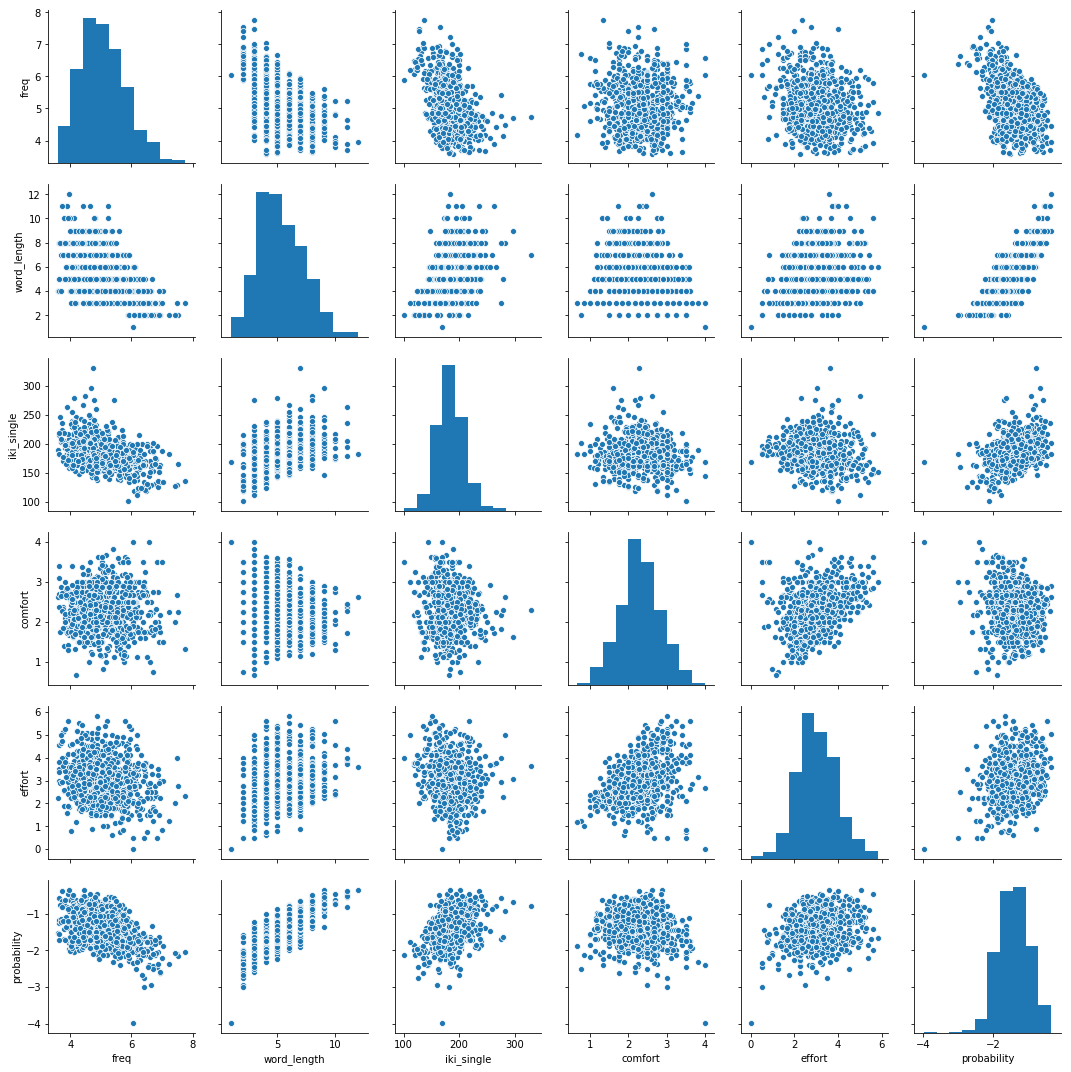

In [509]:
sns.pairplot(data)

In [520]:
X = data[['freq','word_length','iki_natural','effort','comfort']].copy()
X = preprocessing.StandardScaler().fit_transform(X)
y = data['probability'].copy()

X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.20,random_state=0)

reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

/Users/itto/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/itto/miniconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.6383167734157191

#### Logistic regression

In [70]:
mask = words.word_length > 1
mask &= words.word.str.contains('^[a-z]+$')
mask &= words.word_length < 14
data = words.loc[mask,['word','freq','word_length','iki_norm','iki_natural','ite']].copy()

data = data.loc[data.ite != 'autocorr']

data = data.groupby('word').filter(lambda x: x.shape[0] > 50)
data.iki_norm = data.word.map(data.groupby('word').iki_norm.median())
data.iki_natural = data.word.map(data.groupby('word').iki_natural.median())

data = data.dropna()
data.freq = np.log10(data.freq)
data = data.set_index('word')

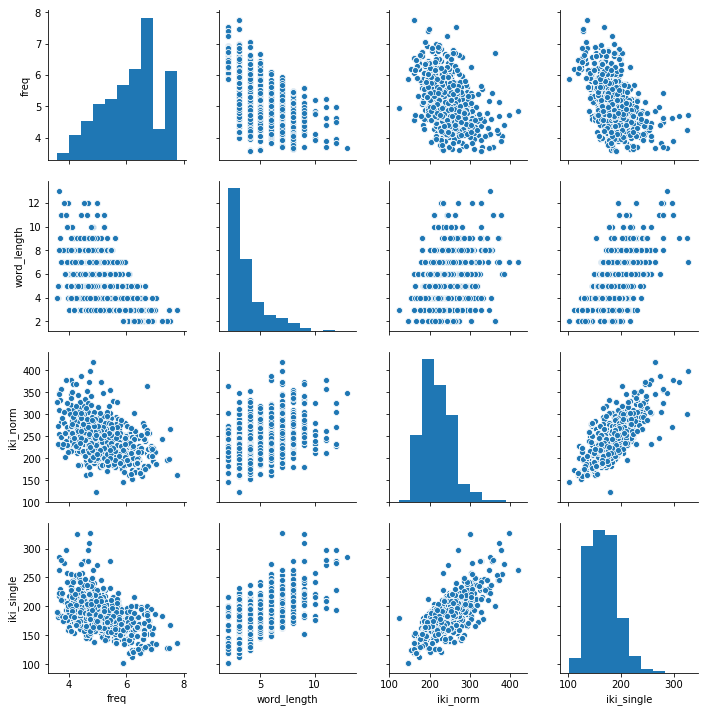

In [71]:
sns.pairplot(data.sample(10000,random_state=0))

In [129]:
X = data.loc[:,data.columns != 'ite'].copy()
X.word_length = X.word_length.astype(float)
X_scaled = preprocessing.StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
y = data['ite'].copy()
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.5,random_state=0)

reg = linear_model.LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=1000, fit_intercept=False)
reg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=1000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [130]:
pd.DataFrame(reg.coef_,columns=X.columns) 

,freq,word_length,iki_norm,iki_single
0,0.055058,0.227926,0.057169,-0.005445


In [135]:
test = X_test.copy()
y_prob = reg.predict_proba(X_test)[:,1]
y_label = reg.predict(X_test)
test['prob'] = y_prob
test['label_pred'] = y_label
test['label_true'] = y_test

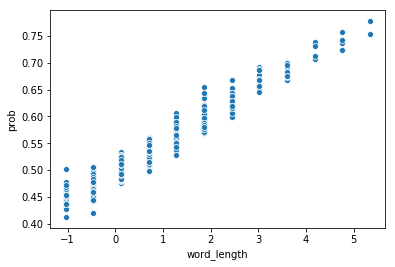

In [137]:
tmp = test.sample(10000)
tmp = tmp.groupby(tmp.index).mean()
sns.scatterplot(tmp.word_length, tmp.prob)

In [108]:
model = sm.MNLogit(y_train,X_train)
model = model.fit(maxiter=1000)

Optimization terminated successfully.
         Current function value: 0.687950
         Iterations 4


In [109]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                    ite   No. Observations:               154759
Model:                        MNLogit   Df Residuals:                   154755
Method:                           MLE   Df Model:                            3
Date:                Wed, 26 Jun 2019   Pseudo R-squ.:                  -3.513
Time:                        20:21:12   Log-Likelihood:            -1.0647e+05
converged:                       True   LL-Null:                       -23593.
                                        LLR p-value:                     1.000
===============================================================================
ite=predict       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
freq            0.0551      0.008      6.858      0.000       0.039       0.071
word_length     0.2279      0.008     28.844      0.000       0.212       0.243
iki_norm        0.0572      0.008      7.145      0.000       0.041       0.073
iki_single     -0.0055      0.009     -0.613      0.540      -0.023       0.012
===============================================================================
"""

In [132]:
y_pred = reg.predict(X_test)
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test,y_pred), index=reg.classes_,columns=reg.classes_)
confusion_matrix

,none,predict
none,100111,49188
predict,1388,4072


## Word clustering

In [ ]:
data = words.loc[words.ite == 'predict']
data = data.loc[data.ite_lev_ratio <= 1]

# Discretize
features_words = pd.DataFrame()
features_words['length'] = pd.cut(data.ite_input_len,[0,3,7,20],labels=['short','medium','long'])
features_words['freq'] = data.freq_category
features_words['ratio'] = pd.cut(data.ite_lev_ratio,[0,0.25,0.5,0.75,0.99,1])

# Other categoricals
features_words['ite2'] = data.ite2

# To dummy
features_words = pd.get_dummies(features_words)
features_words = features_words.astype('bool')
features_words = features_words.sample(1500)

# No standardization necessary
features_words_ss = features_words.copy()

In [ ]:
features_words_embedded = umap.UMAP(90,metric='jaccard',min_dist=0.01).fit_transform(features_words_ss)
features_words_embedded = pd.DataFrame(features_words_embedded,columns=['x','y'])

In [ ]:
f,ax = plt.subplots(5,4,figsize=(15,18))
ax = ax.flatten()

f.tight_layout(w_pad=3,h_pad=3)

sections = features_words_ss.columns

for i,section in enumerate(sections[:]):
    ax[i].scatter(
        features_words_embedded.x,
        features_words_embedded.y,
        c=features_words_ss[section],
        s=1,
    )
    ax[i].set_title(section)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [ ]:
f.savefig('/Users/itto/Downloads/umap_categorical_80_jaccard_001.svg',dpi=300)

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=40)
clusterer.fit(features_words_embedded)

features_words_embedded['label'] = clusterer.labels_
features_words_embedded['prob'] = clusterer.probabilities_

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

im = ax1.scatter(
    features_words_embedded.x,
    features_words_embedded.y,
    c=features_words_embedded.label,
    s = 5
)
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
f.colorbar(im,ax=ax1)

im = ax2.scatter(
    features_words_embedded.x,
    features_words_embedded.y,
    c=features_words_embedded.prob,
    cmap='copper',
    s = 5
)
ax2.set_aspect('equal')
ax2.set_xticks([])
ax2.set_yticks([])
f.colorbar(im,ax=ax2)

f.tight_layout()

In [ ]:
f.savefig('/Users/itto/Downloads/hdbscan_categorical_80_jaccard_001.svg',dpi=300)

In [ ]:
results = pd.DataFrame(index=features_words_ss.index)
results['label'] = features_words_embedded.label.values
results.label.value_counts()

In [ ]:
f,ax = plt.subplots(2,2,figsize=(15,8))
f.tight_layout(w_pad=5,h_pad=5)
ax = ax.flatten()

data = words.reindex(results.index).copy()

# 1
sns.stripplot(x=results.label,y=data.ite_input_len,ax=ax[0])
# 2
g = sns.boxplot(x=results.label,y=data.freq,ax=ax[1])
g.set_yscale('log')
# 3
data.groupby(results.label).freq_category.value_counts(normalize=True).unstack().plot.bar(stacked=True,ax=ax[2])
# 4
g = sns.stripplot(x=results.label,y=data.ite_lev_ratio,ax=ax[3])

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

sns.boxplot(x=results.label,y=data.iki_norm,ax=ax1)
ax1.set_ylim(0,800)

sns.boxplot(x=results.label,y=data.ite_iki,ax=ax2)
ax2.set_ylim(300,2000)

f.tight_layout()